# Robustness of founded policies

1) Regret
2) satisfying
3) signal noise_to_ratio

In [1]:
# Import general python packages
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt
import seaborn as sns

# Import functions
from dike_model_function import DikeNetwork  # @UnresolvedImport
from problem_formulation import get_model_for_problem_formulation
from problem_formulation import sum_over,time_step_0,time_step_1, time_step_2, time_step_3, time_step_4
from sklearn.cluster import KMeans

# Loading in the necessary modules for EMA workbench and functions
from ema_workbench import (Model, MultiprocessingEvaluator, Scenario,
                           Constraint, ScalarOutcome, TimeSeriesOutcome, ArrayOutcome)
from ema_workbench.util import ema_logging
from ema_workbench import save_results, load_results, Policy
from ema_workbench.em_framework.optimization import (EpsilonProgress)
from ema_workbench.analysis import parcoords

### Initializing model

In [2]:

def initialize_model():
    ema_logging.log_to_stderr(ema_logging.INFO)
    print("Initializing model...")
    dike_model, planning_steps = get_model_for_problem_formulation(7)
    print("Model initialized.")
    return dike_model, planning_steps

# Writing a function to create actor specific problem formulations
def problem_formulation_actor(problem_formulation_actor, uncertainties, levers):
    # Load the model:
    function = DikeNetwork()
    # workbench model:
    model = Model('dikesnet', function=function)
    # Outcomes are all costs, thus they have to minimized:
    direction = ScalarOutcome.MINIMIZE

    model.uncertainties = uncertainties
    model.levers = levers

    cost_variables = []
    cost_variables.extend(
    [
        f"{dike}_{e}"
        for e in ["Expected Annual Damage", "Dike Investment Costs"]
        for dike in function.dikelist
    ])
    cost_variables.extend([f"RfR Total Costs"])
    cost_variables.extend([f"Expected Evacuation Costs"])

    if problem_formulation_actor == 6:  # GELDERLAND
        model.outcomes.clear()
        model.outcomes = [
            ScalarOutcome(f'Total_period_Costs_0',
                          variable_name=dike_model.outcomes['Total_period_Costs'].variable_name,
                          function=time_step_0, kind=direction),
            ScalarOutcome(f'Total_period_Costs_1',
                          variable_name=dike_model.outcomes['Total_period_Costs'].variable_name,
                          function=time_step_1, kind=direction),
            ScalarOutcome(f'Total_period_Costs_2',
                          variable_name=dike_model.outcomes['Total_period_Costs'].variable_name,
                          function=time_step_2, kind=direction),
            # ScalarOutcome(f'Total_period_Costs_3',
            #               variable_name=dike_model.outcomes['Total_period_Costs'].variable_name,
            #               function=time_step_3, kind=direction),
            # ScalarOutcome(f'Total_period_Costs_4',
            #               variable_name=dike_model.outcomes['Total_period_Costs'].variable_name,
            #               function=time_step_4, kind=direction),
            ScalarOutcome('Expected Annual Damage A1_', variable_name='A.1_Expected Annual Damage', function=sum_over,
                          kind=direction),
            ScalarOutcome('Expected Annual Damage A2_', variable_name='A.2_Expected Annual Damage', function=sum_over,
                          kind=direction),
            ScalarOutcome('Expected Annual Damage A3_', variable_name='A.3_Expected Annual Damage', function=sum_over,
                          kind=direction),
            ScalarOutcome('Total Costs', variable_name=cost_variables, function=sum_over, kind=direction),
            ScalarOutcome("Expected Number of Deaths_", variable_name=
            [f"{dike}_Expected Number of Deaths" for dike in function.dikelist], function=sum_over, kind=direction)]


    elif problem_formulation_actor == 7:  # OVERIJSSEL
        model.outcomes.clear()
        model.outcomes = [
            ScalarOutcome(f'Total_period_Costs_0',
                          variable_name=dike_model.outcomes['Total_period_Costs'].variable_name,
                          function=time_step_0, kind=direction),
            ScalarOutcome(f'Total_period_Costs_1',
                          variable_name=dike_model.outcomes['Total_period_Costs'].variable_name,
                          function=time_step_1, kind=direction),
            ScalarOutcome(f'Total_period_Costs_2',
                          variable_name=dike_model.outcomes['Total_period_Costs'].variable_name,
                          function=time_step_2, kind=direction),
            # ScalarOutcome(f'Total_period_Costs_3',
            #               variable_name=dike_model.outcomes['Total_period_Costs'].variable_name,
            #               function=time_step_3, kind=direction),
            # # ScalarOutcome(f'Total_period_Costs_4',
            #               variable_name=dike_model.outcomes['Total_period_Costs'].variable_name,
            #               function=time_step_4, kind=direction),
            ScalarOutcome('Expected Annual Damage A4_', variable_name='A.4_Expected Annual Damage', function=sum_over,
                          kind=direction),
            ScalarOutcome('Expected Annual Damage A5_', variable_name='A.5_Expected Annual Damage', function=sum_over,
                          kind=direction),
            ScalarOutcome('Total Costs', variable_name=cost_variables, function=sum_over, kind=direction),
            ScalarOutcome("Expected Number of Deaths_", variable_name=
            [f"{dike}_Expected Number of Deaths" for dike in function.dikelist], function=sum_over, kind=direction)]

    else:
        raise TypeError('unknown identifier')
    return model

### Overijssel
if __name__ == '__main__':
    dike_model, planning_steps = initialize_model()

    uncertainties = dike_model.uncertainties
    levers = dike_model.levers
    
    model = problem_formulation_actor(7, uncertainties, levers)

    # Deepcopying the uncertainties and levers
    uncertainties = copy.deepcopy(dike_model.uncertainties)
    levers = copy.deepcopy(dike_model.levers)

    # Running the optimization for Overijssel
    function = DikeNetwork()

Initializing model...
Model initialized.


In [29]:
policy_set= pd.read_csv("Gelderland_Multi_MORDM_outcomes.csv")

#add column indicating under which scenario which policy was found
policy_snip=[]
for i in range (1, 8):
    policy_snip.append(policy_set.iloc[:,-i].idxmin())
    policy_snip.append(policy_set.iloc[:,-i].idxmax())

pareto_df= policy_set

# Selecteer de laatste 7 kolommen (objectieven)
objective_columns = pareto_df.columns[-7:]

# Verdeel elke doelstelling in 3 segmenten en selecteer één oplossing uit elk segment
selected_policies = pd.DataFrame()

for objective in objective_columns:
    # Sorteer de Pareto-set op de huidige doelstelling
    pareto_df_sorted = pareto_df.sort_values(by=objective)
    
    # Verdeel de Pareto-set in 3 gelijke segmenten
    indices = np.linspace(0, len(pareto_df_sorted) - 1, 4, dtype=int)
    
    # Omzetten naar een enkele lijst van indices
    selected_indices = (indices[:-1] + np.diff(indices) // 2).tolist()
    
    # Selecteer de rijen met de geselecteerde indices en voeg toe aan selected_policies
    selected_policies = pd.concat([selected_policies, pareto_df_sorted.iloc[selected_indices]])

policy_snip2=  selected_policies.index.tolist()
policy_snip2

total_snip= policy_snip + policy_snip2
len(total_snip) #35 = 14+21 dus klopt
unique_snip = list(set(total_snip))
unique_snip

policies = policy_set.loc[unique_snip]
policies = policies.iloc[:,1:51]


rcase_policies = []
for i, policy in policies.iterrows():
    rcase_policies.append(Policy(str(i), **policy.to_dict()))

n_scenarios = 1000
with MultiprocessingEvaluator(model) as evaluator:
    reference_policies_results = evaluator.perform_experiments(n_scenarios,
                                            rcase_policies)
save_results(reference_policies_results, 'MultiMORDM_G.tar.gz')

[MainProcess/INFO] pool started with 8 workers
[MainProcess/INFO] performing 100 scenarios * 33 policies * 1 model(s) = 3300 experiments

100%|██████████████████████████████████████| 3300/3300 [24:31<00:00,  2.24it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool
[MainProcess/INFO] results saved successfully to C:\Users\CLDert\PycharmProjects\epa141A_group3(1)\final_ass_time_changed\MultiMORDM_G.tar.gz


### Loading in the datasets

In [30]:
experiments, outcomes = load_results('MultiMORDM_G.tar.gz')

df_exp = pd.DataFrame.from_dict(experiments)
df_out = pd.DataFrame.from_dict(outcomes)

[MainProcess/INFO] results loaded successfully from C:\Users\CLDert\PycharmProjects\epa141A_group3(1)\final_ass_time_changed\MultiMORDM_G.tar.gz


In [31]:
experiments

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.4_DikeIncrease 3,A.4_DikeIncrease 4,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,A.5_DikeIncrease 3,A.5_DikeIncrease 4,scenario,policy,model
0,10,217.713951,1.5,0.542894,279.005580,1.5,0.372593,143.219759,1.5,0.786134,...,0,1,0,2,0,0,3,2000,0,dikesnet
1,89,279.898019,1.0,0.361762,146.841309,1.5,0.211278,230.686324,1.0,0.746000,...,0,1,0,2,0,0,3,2001,0,dikesnet
2,59,72.514281,1.5,0.691982,190.881968,1.0,0.182313,48.647398,1.0,0.130697,...,0,1,0,2,0,0,3,2002,0,dikesnet
3,78,274.189427,10.0,0.983202,325.655181,1.0,0.015955,188.602215,1.0,0.324302,...,0,1,0,2,0,0,3,2003,0,dikesnet
4,61,287.317931,1.0,0.784329,320.408941,10.0,0.587017,152.093094,1.0,0.012351,...,0,1,0,2,0,0,3,2004,0,dikesnet
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3295,84,214.796700,10.0,0.349324,36.280957,10.0,0.686938,216.808479,1.5,0.931651,...,1,5,3,0,0,0,0,2095,1023,dikesnet
3296,125,117.141831,10.0,0.759781,140.261142,10.0,0.655724,283.754378,1.0,0.210997,...,1,5,3,0,0,0,0,2096,1023,dikesnet
3297,25,141.861584,10.0,0.461343,104.431760,1.0,0.439910,177.485411,1.0,0.690066,...,1,5,3,0,0,0,0,2097,1023,dikesnet
3298,24,343.959290,1.0,0.919786,77.518389,1.0,0.394526,147.866375,10.0,0.513022,...,1,5,3,0,0,0,0,2098,1023,dikesnet


In [32]:
for _ in outcomes:
    print(_)

Total_period_Costs_0
Total_period_Costs_1
Total_period_Costs_2
Expected Annual Damage A4_
Expected Annual Damage A5_
Total Costs
Expected Number of Deaths_


In [33]:
policies = experiments.iloc[:,21:]
policies

,0_RfR 1,0_RfR 2,0_RfR 3,0_RfR 4,1_RfR 0,1_RfR 1,1_RfR 2,1_RfR 3,1_RfR 4,2_RfR 0,...,A.4_DikeIncrease 3,A.4_DikeIncrease 4,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,A.5_DikeIncrease 3,A.5_DikeIncrease 4,scenario,policy,model
0,0,1,0,0,0,0,0,0,0,0,...,0,1,0,2,0,0,3,2000,0,dikesnet
1,0,1,0,0,0,0,0,0,0,0,...,0,1,0,2,0,0,3,2001,0,dikesnet
2,0,1,0,0,0,0,0,0,0,0,...,0,1,0,2,0,0,3,2002,0,dikesnet
3,0,1,0,0,0,0,0,0,0,0,...,0,1,0,2,0,0,3,2003,0,dikesnet
4,0,1,0,0,0,0,0,0,0,0,...,0,1,0,2,0,0,3,2004,0,dikesnet
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3295,0,0,0,0,0,0,0,0,0,1,...,1,5,3,0,0,0,0,2095,1023,dikesnet
3296,0,0,0,0,0,0,0,0,0,1,...,1,5,3,0,0,0,0,2096,1023,dikesnet
3297,0,0,0,0,0,0,0,0,0,1,...,1,5,3,0,0,0,0,2097,1023,dikesnet
3298,0,0,0,0,0,0,0,0,0,1,...,1,5,3,0,0,0,0,2098,1023,dikesnet


In [34]:
df_out

,Total_period_Costs_0,Total_period_Costs_1,Total_period_Costs_2,Expected Annual Damage A4_,Expected Annual Damage A5_,Total Costs,Expected Number of Deaths_
0,2.103671e+08,1.800566e+08,2.496335e+08,2.024584e+07,5.084525e+08,8.871212e+08,0.071599
1,3.492143e+07,9.319966e+07,2.051239e+08,5.563240e+07,0.000000e+00,4.822273e+08,0.016080
2,2.585059e+07,8.026974e+07,2.053982e+08,0.000000e+00,0.000000e+00,4.554958e+08,0.017142
3,2.964994e+08,2.699360e+08,3.863808e+08,0.000000e+00,0.000000e+00,1.447043e+09,0.150456
4,3.077540e+08,3.234721e+08,2.407828e+08,1.806079e+08,0.000000e+00,1.169695e+09,0.201067
...,...,...,...,...,...,...,...
3295,1.199247e+08,9.409498e+06,8.998132e+07,8.503690e+06,2.162688e+07,3.268012e+08,0.070192
3296,2.169457e+08,1.123182e+08,1.699054e+08,2.066076e+06,4.803928e+08,7.914953e+08,0.667093
3297,1.124777e+08,9.227815e+06,8.415795e+07,7.652880e+06,2.684253e+07,3.117248e+08,0.053587
3298,1.137288e+08,1.479615e+07,8.329473e+07,8.797712e+06,0.000000e+00,3.033146e+08,0.042910


### 1. Regret

In [35]:
import pandas as pd
import numpy as np

def calculate_regret(data, best):
    return np.abs(best-data)

worstcase_regret = {}
worstcase_max_regret = {}

for outcome in model.outcomes:
    policy_column = experiments['policy']
    
    # Create a DataFrame with all the relevant information
    data = pd.DataFrame({
        outcome.name: outcomes[outcome.name], 
        "policy": experiments['policy'],
        "scenario_id": experiments['scenario']
    })
    
    # Reorient the data by indexing with policy and scenario_id
    data = data.pivot(index='scenario_id', columns='policy')
    
    # Flatten the resulting hierarchical index resulting from pivoting
    data.columns = data.columns.get_level_values(1)
   
    # Control the broadcasting by converting to NumPy arrays
    max_values = data.max(axis=1).to_numpy()[:, np.newaxis]
    data_values = data.to_numpy()
    
    # Calculate the outcome regret
    outcome_regret = np.abs(max_values - data_values)
    
    # Store the results
    worstcase_regret[outcome.name] = outcome_regret
    worstcase_max_regret[outcome.name] = outcome_regret.max(axis=0)

# Convert the results to DataFrames if needed
#worstcase_regret_df = pd.DataFrame(worstcase_regret)
# worstcase_max_regret_df = pd.DataFrame(worstcase_max_regret)
# 
# worstcase_regret_df, worstcase_max_regret_df

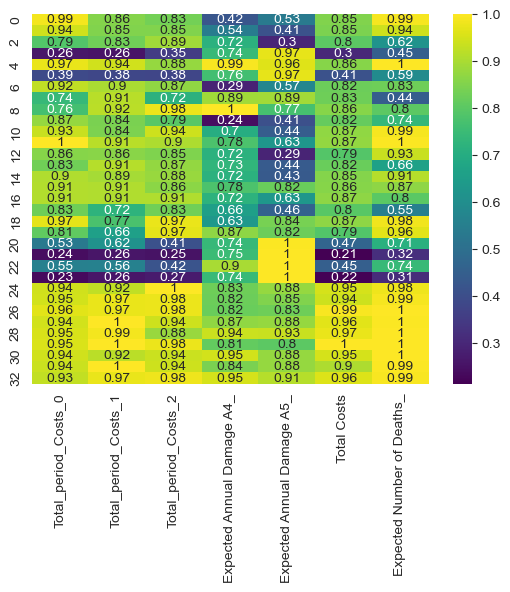

In [36]:
worstcase_max_regret = pd.DataFrame(worstcase_max_regret)
sns.heatmap(worstcase_max_regret/worstcase_max_regret.max(), cmap='viridis', annot=True)
plt.show()

IndexError: list index out of range

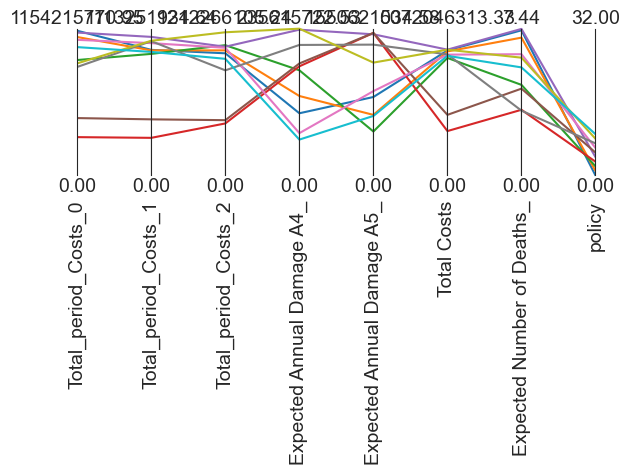

In [44]:
colors = sns.color_palette()

data = worstcase_max_regret

# makes it easier to identify the policy associated with each line
#in the parcoords plot
#data['policy'] = data.index.astype("float64")

limits = parcoords.get_limits(data)
limits.loc[0, ['Total_period_Costs_0', 'Total_period_Costs_1', 'Total_period_Costs_2','Expected Annual Damage A4_', 'Expected Annual Damage A5_', 'Total Costs', 'Expected Number of Deaths_']] = 0

paraxes = parcoords.ParallelAxes(limits)
for i, (index, row) in enumerate(data.iterrows()):
    paraxes.plot(row.to_frame().T, label=str(index), color=colors[i])
paraxes.legend()
    
plt.show()

In [38]:
#no need for distribution as max regret is what we are intrested in especially with deaths and damages.. MAX regret is how good it could have been in a certain scenario if you would have chosen another policy

### 2. Signal to Noise

In [39]:
def signalnoise(data, direction):
    mean = np.mean(data)
    std = np.std(data)
    
    #We minimize all objectives therefore a lower mean and lower std is wanted, so we want the outcome to be as small as possible
    if direction==ScalarOutcome.MAXIMIZE:
        return mean/std
    else:
        return mean*std

In [40]:
overall_scores = {}
for policy in np.unique(experiments['policy']):
    scores = {}
    
    logical = experiments['policy']==policy
    
    for outcome in model.outcomes:
        value  = outcomes[outcome.name][logical]
        sn_ratio = signalnoise(value, outcome.kind)
        scores[outcome.name] = sn_ratio
    overall_scores[policy] = scores
scores = pd.DataFrame.from_dict(overall_scores).T
scores

,Total_period_Costs_0,Total_period_Costs_1,Total_period_Costs_2,Expected Annual Damage A4_,Expected Annual Damage A5_,Total Costs,Expected Number of Deaths_
0,4.472066e+16,5.530466e+16,3.485475e+16,2.434834e+15,1.848898e+16,7.788192e+17,0.006388
2,5.246085e+16,5.610953e+16,4.832842e+16,1.028025e+15,2.830420e+16,9.662158e+17,0.464283
7,8.133246e+16,6.486273e+16,6.111997e+16,3.878430e+14,6.455102e+16,1.554933e+18,1.687032
13,1.333816e+17,1.312986e+17,1.356652e+17,7.622133e+14,5.115887e+16,3.091769e+18,2.650724
108,6.082776e+16,3.055816e+16,3.981109e+16,7.285072e+10,3.491776e+14,8.650874e+17,0.004499
109,1.260848e+17,1.247048e+17,1.428726e+17,1.642061e+14,6.188370e+16,3.024684e+18,2.258966
187,3.972111e+16,3.113992e+16,3.047657e+16,1.680135e+15,1.414686e+16,7.835546e+17,0.471504
194,7.780670e+16,5.582507e+16,7.778992e+16,6.293528e+14,8.578194e+15,1.540840e+18,2.387469
241,1.115682e+17,4.165800e+16,3.746957e+16,2.205774e+10,3.629958e+15,1.354564e+18,0.905332
320,5.600620e+16,4.686611e+16,6.191554e+16,2.593470e+15,3.905883e+16,1.012753e+18,0.683197


C:\Users\CLDert\AppData\Roaming\Python\Python311\site-packages\ema_workbench\analysis\parcoords.py:220: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout(h_pad=0, w_pad=0)


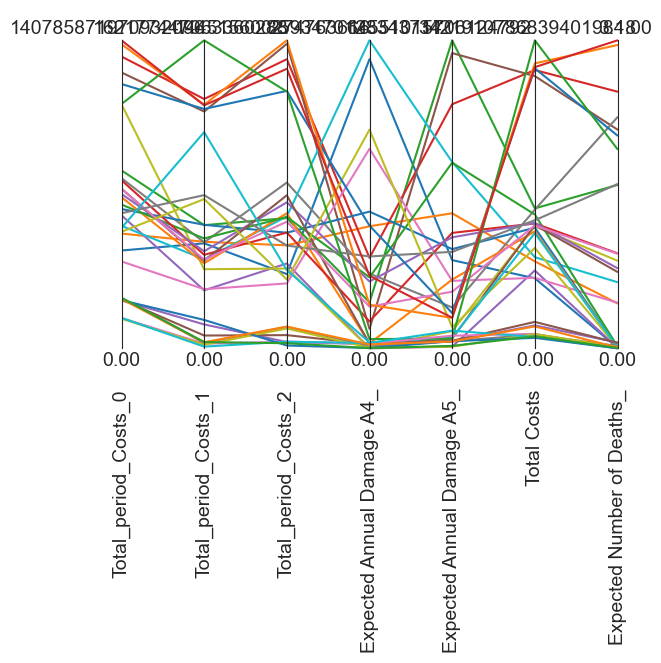

In [41]:
from ema_workbench.analysis import parcoords

data = scores
limits = parcoords.get_limits(data)
limits.loc[0, ['Total_period_Costs_0', 'Total_period_Costs_1', 'Total_period_Costs_2','Expected Annual Damage A4_', 'Expected Annual Damage A5_', 'Total Costs', 'Expected Number of Deaths_']] = 0

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
#paraxes.invert_axis('max_P')
plt.show()

In [ ]:
#This shows the Signal to Noice, which is expected * standard deviation for our minimization. a lower score is better. This is about over different scenarios the average and standard deviation, punishing for too much deviation over the scenarios.

##  3. Satisficing

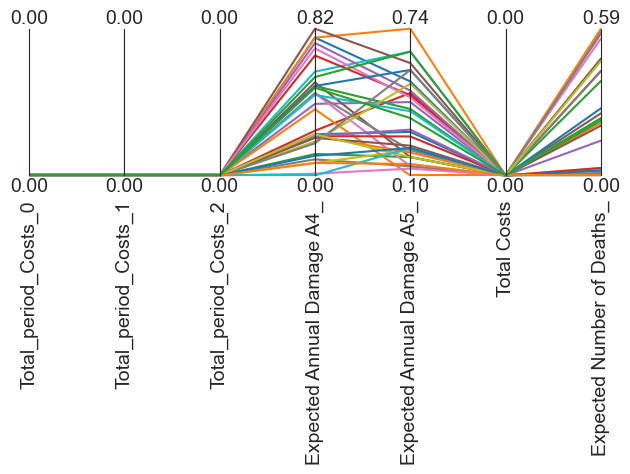

In [46]:

thresholds = {'Total_period_Costs_0':2500000000, 'Total_period_Costs_1':2000000000, 'Total_period_Costs_2':2000000000, 'Expected Annual Damage A4_': 2000000, 'Expected Annual Damage A5_': 2000000, 'Total Costs': 7000000000, 'Expected Number of Deaths_': 1}


overall_scores = {}
for policy in experiments.policy.unique():
    logical = experiments.policy == policy
    scores = {}
    for k, v in outcomes.items():
        try:
            n = np.sum(v[logical]>=thresholds[k])
        except KeyError:
            continue
        scores[k] = n/100 #set to number of scenarios
    overall_scores[policy] = scores
        
overall_scores = pd.DataFrame(overall_scores).T
limits = parcoords.get_limits(overall_scores)
paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(overall_scores)
plt.show()

In [ ]:
#hoeveel procent van de scenarios gaat een policy over the treshold heen van een bepaalde objective? is heirbovenhet antwoord 